In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("cleaned_nacional.csv", encoding='latin-1')

"Caracterísitica de la vía"

In [ ]:
print(df['URBANA'].value_counts())
print(df['SUBURBANA'].value_counts())
print(df['CAPAROD'].value_counts())

URBANA
1    172459
2      5638
0      2122
Name: count, dtype: int64
SUBURBANA
0    178097
2      1228
3       682
1       212
Name: count, dtype: int64
CAPAROD
1    179376
2       843
Name: count, dtype: int64


In [ ]:
import pandas as pd

#TOTMUERTOS promedio según URBANA
print(df.groupby('URBANA')['TOTMUERTOS'].mean())

# O un crosstab con rangos de TOTMUERTOS
# Primero creamos una categoría binaria o por rangos de TOTMUERTOS
df['FATAL'] = (df['TOTMUERTOS'] > 0).astype(int)
pd.crosstab(df['URBANA'], df['FATAL'])

URBANA
0    0.042884
1    0.005787
2    0.009223
Name: TOTMUERTOS, dtype: float64


FATAL,0,1
URBANA,,
0,2044,78
1,171526,933
2,5591,47


URBANA=0: “2044 accidentes sin muertes, 78 con muertes”.
URBANA=1: “171,526 accidentes sin muertes, 2,393 con muertes”.
URBANA=2: “5,891 accidentes sin muertes, 47 con muertes”.

In [ ]:
df['CAPAROD'].value_counts()

,count
CAPAROD,
1,179376
2,843


In [ ]:
pd.crosstab(df['CAPAROD'], df['TIPACCID'])

TIPACCID,1,2,3,4,5,6,7,8,9,10,11,12
CAPAROD,,,,,,,,,,,,
1,124785,5866,121,24169,1846,674,1225,75,100,16751,2052,1712
2,422,39,3,250,25,2,20,0,2,38,25,17


Tipos de accidente son más comunes en cierto estado del pavimento.

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

columnas = [
    'URBANA',     # 0 o 1
    'SUBURBANA',  # 0 o 1
    'CAPAROD',    # si es código numérico (1,2,3...) o dummies
    'TOTMUERTOS',
    'TOTHERIDOS'
]

df_sub = df[columnas].copy()
df_sub.dropna(inplace=True)  # eliminar nulos

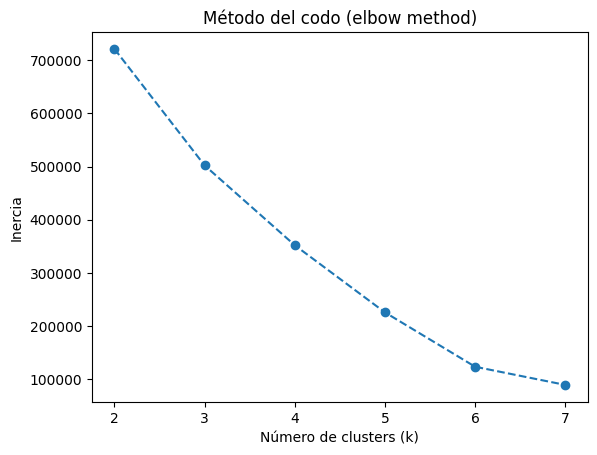

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_sub)

inertia = []
K_range = range(2, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

import matplotlib.pyplot as plt
plt.plot(K_range, inertia, 'o--')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo (elbow method)")
plt.show()

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df_scaled)

df_sub['cluster'] = labels

In [ ]:
print(df_sub['cluster'].value_counts())

cluster
0    170747
4      5558
1      2057
3      1014
2       843
Name: count, dtype: int64


In [ ]:
df_sub.groupby('cluster').mean()

,URBANA,SUBURBANA,CAPAROD,TOTMUERTOS,TOTHERIDOS
cluster,,,,,
0,1.000000,0.000000,1.0,0.000000,0.185795
1,0.000000,2.236753,1.0,0.017501,0.283909
2,1.013049,0.043891,2.0,0.009490,0.205219
3,1.003945,0.074951,1.0,1.081854,0.409270
4,2.000000,0.000000,1.0,0.000000,0.208708


In [ ]:
df['cluster'] = df_sub['cluster']  # unir la info de clusters al df original
pd.crosstab(df['cluster'], df['TIPACCID'])

TIPACCID,1,2,3,4,5,6,7,8,9,10,11,12
cluster,,,,,,,,,,,,
0,120327,5250,83,22450,1538,627,968,71,83,15898,1871,1581
1,1050,40,31,343,125,9,177,2,9,184,20,67
2,422,39,3,250,25,2,20,0,2,38,25,17
3,191,388,1,141,46,20,13,0,8,142,55,9
4,3217,188,6,1235,137,18,67,2,0,527,106,55


Distribución de Accidentes Fatales por Tipo de Pavimento

In [ ]:
print("\nDistribución de accidentes fatales por tipo de pavimento:")
fatal_by_pavement = pd.crosstab(df['CAPAROD'], df['FATAL'])
print(fatal_by_pavement)


Distribución de accidentes fatales por tipo de pavimento:
FATAL         0     1
CAPAROD              
1        178326  1050
2           835     8


Relación entre Tipo de Pavimento y Número de Heridos

In [ ]:
print("\nNúmero promedio de heridos según el tipo de pavimento:")
print(df.groupby('CAPAROD')['TOTHERIDOS'].mean())


Número promedio de heridos según el tipo de pavimento:
CAPAROD
1    0.188894
2    0.205219
Name: TOTHERIDOS, dtype: float64


Mapa de Calor de Accidentes Fatales

In [ ]:
import folium
from folium.plugins import HeatMap

# Filtrar solo accidentes fatales
fatal_accidents = df[df['FATAL'] == 1]

# Crear un mapa centrado en una ubicación promedio
map_fatal = folium.Map(location=[21.88, -102.30], zoom_start=12)

# Generar puntos de calor basados en latitud y longitud
heat_data = [[row['LATITUD'], row['LONGITUD']] for index, row in fatal_accidents.iterrows()]
HeatMap(heat_data).add_to(map_fatal)

# Guardar el mapa en un archivo HTML
map_fatal.save("accidentes_fatales_heatmap.html")

Rojo/Amarillo (Centro Caliente): Alta concentración de accidentes fatales:
-Alta densidad de tráfico.
-Calles congestionadas o de alta velocidad.
-Mayor volumen de vehículos y peatones.

Azul (Centro Frío): Baja concentración de accidentes fatales.
-Menor volumen de tráfico.
-Vías menos transitadas.

Cada punto en el mapa representa la ubicación geográfica real de un accidente fatal registrado en el dataset (latitud y longitud).

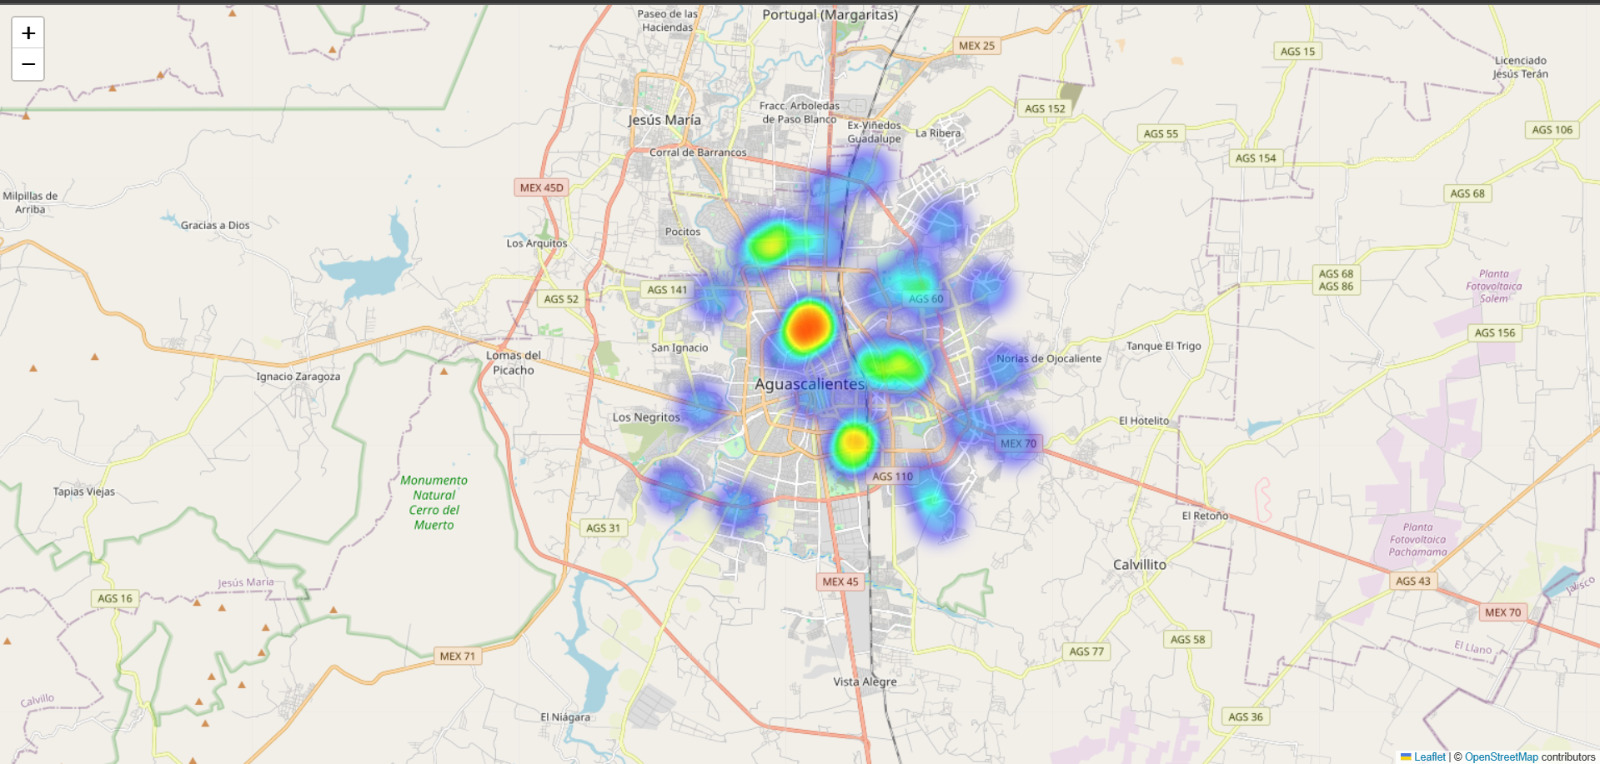

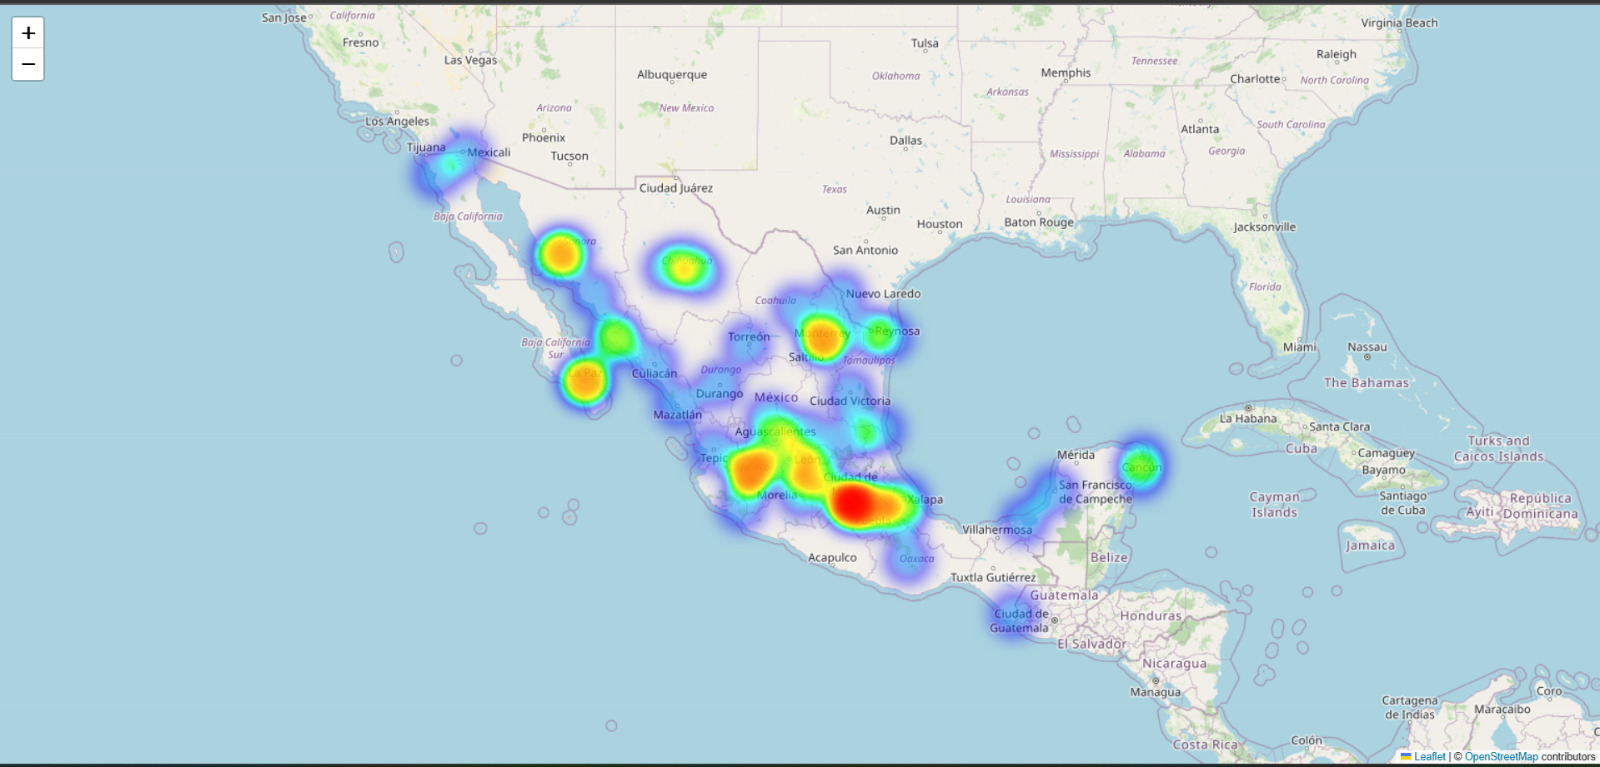